In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Dataset, random_split

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.linalg import sqrtm
import numpy as np
import os
from PIL import Image

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [29]:
def evaluate_accuracy(loader, model):
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [30]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.eval()
model.to(device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [6]:
acc = evaluate_accuracy(testloader, model)
print(acc)

92.6


In [7]:
def fgsm_perturbation(image, epsilon, grad):
    noise = grad.sign()
    perturbed_image = image + epsilon * noise
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, noise

def fgsm_attack(model, loader, epsilon):
    examples = []  
    total = 0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad

        perturbed_images, noise = fgsm_perturbation(images, epsilon, grad)

        outputs_adv = model(perturbed_images)
        _, predicted_adv = torch.max(outputs_adv, 1)

        if len(examples) < 5:
            for i in range(images.size(0)):
                if predicted_adv[i] != labels[i]:
                    examples.append((images[i].cpu(), noise[i].cpu(), perturbed_images[i].cpu(), labels[i].cpu(), predicted_adv[i].cpu()))
                if len(examples) >= 5:
                    break

        correct += (predicted_adv == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy, examples

In [34]:
def plot_examples(examples):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 15))
    
    for i, (orig_img, noise, adv_img, true_label, pred_label) in enumerate(examples):
        orig_img = np.transpose(orig_img.detach().numpy(), (1, 2, 0))  
        noise = np.transpose(noise.detach().numpy(), (1, 2, 0))  
        adv_img = np.transpose(adv_img.detach().numpy(), (1, 2, 0))

        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Original\nTrue: {classes[true_label.item()]}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(noise, cmap="gray")
        axes[i, 1].set_title("Perturbation (Noise)")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(adv_img)
        axes[i, 2].set_title(f"Adversarial\nPred: {classes[pred_label.item()]}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

40.78


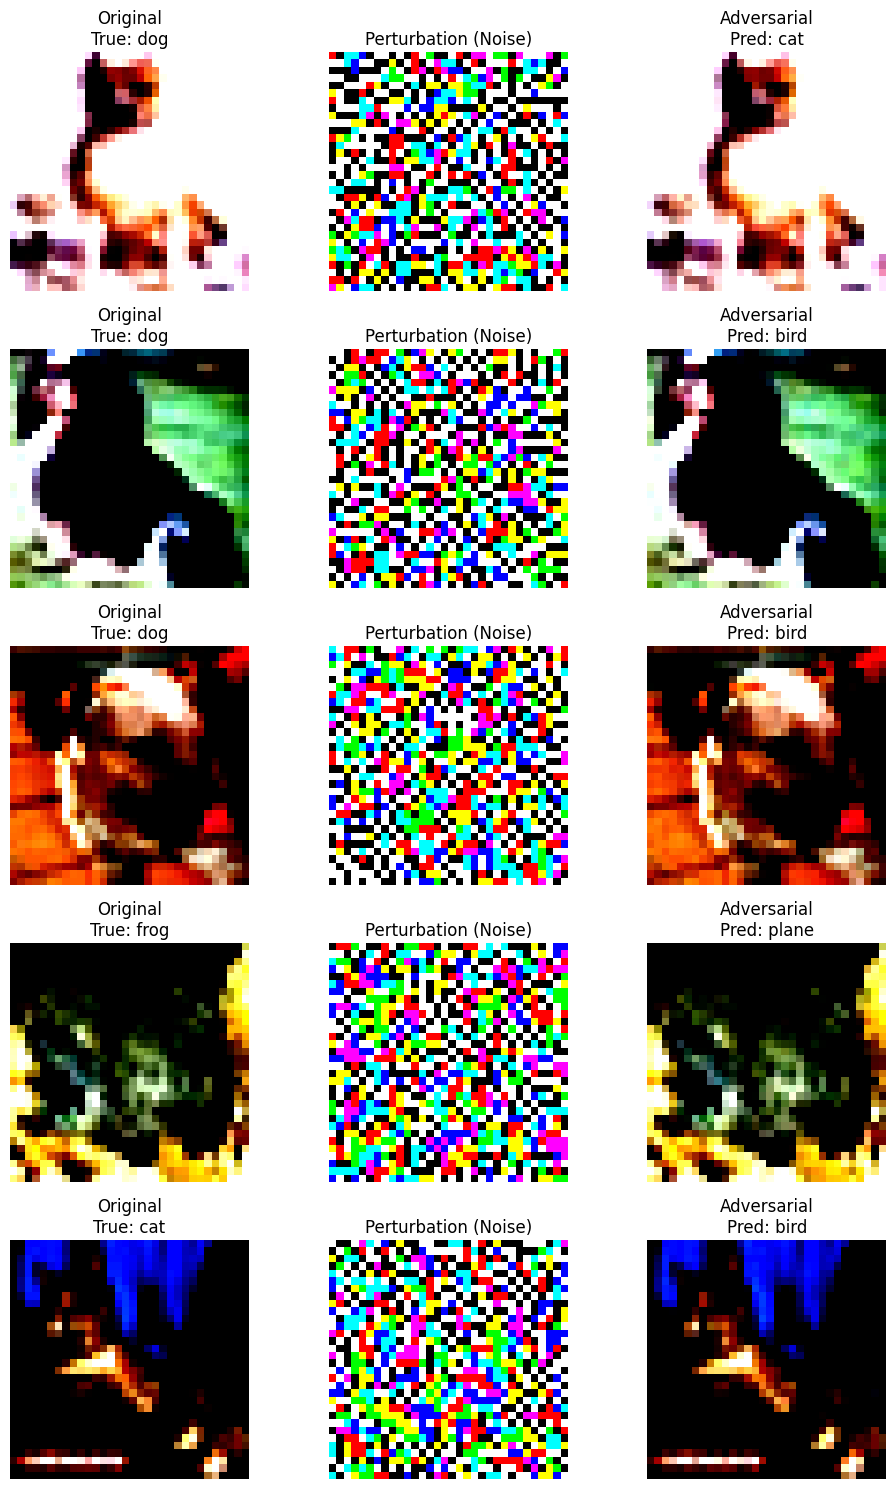

In [46]:
fgsm_acc, examples = fgsm_attack(model, testloader, 0.03)
print(fgsm_acc)

plot_examples(examples)

In [47]:
def ps(epsilon, original_image, perturbed_image):
    perturbation = torch.clamp(perturbed_image - original_image, -epsilon, epsilon)
    perturbed_image = original_image + perturbation
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    noise = (perturbed_image - original_image)
    return perturbed_image, noise

def pgd_attack(model, loader, epsilon, alpha, pgd_iter):
    examples = []
    total = 0
    correct = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        perturbed_images = images.clone().detach()
        
        for _ in range(pgd_iter):
            perturbed_images.requires_grad = True
            outputs = model(perturbed_images)
            loss = F.cross_entropy(outputs, labels)
            
            model.zero_grad()
            loss.backward()
            grad = perturbed_images.grad.data
            
            with torch.no_grad():
                perturbed_images, noise = ps(epsilon, images, perturbed_images + alpha * grad.sign())
        
        with torch.no_grad():
            outputs_adv = model(perturbed_images)
            _, predicted_adv = torch.max(outputs_adv.data, 1)
            
            if len(examples) < 5:
                for i in range(images.size(0)):
                    if predicted_adv[i] != labels[i]:
                        examples.append((
                            images[i].cpu(), 
                            noise[i].cpu(), 
                            perturbed_images[i].cpu(), 
                            labels[i].cpu(), 
                            predicted_adv[i].cpu()
                        ))
                    if len(examples) >= 5:
                        break
            
            correct += (predicted_adv == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy, examples

7.74


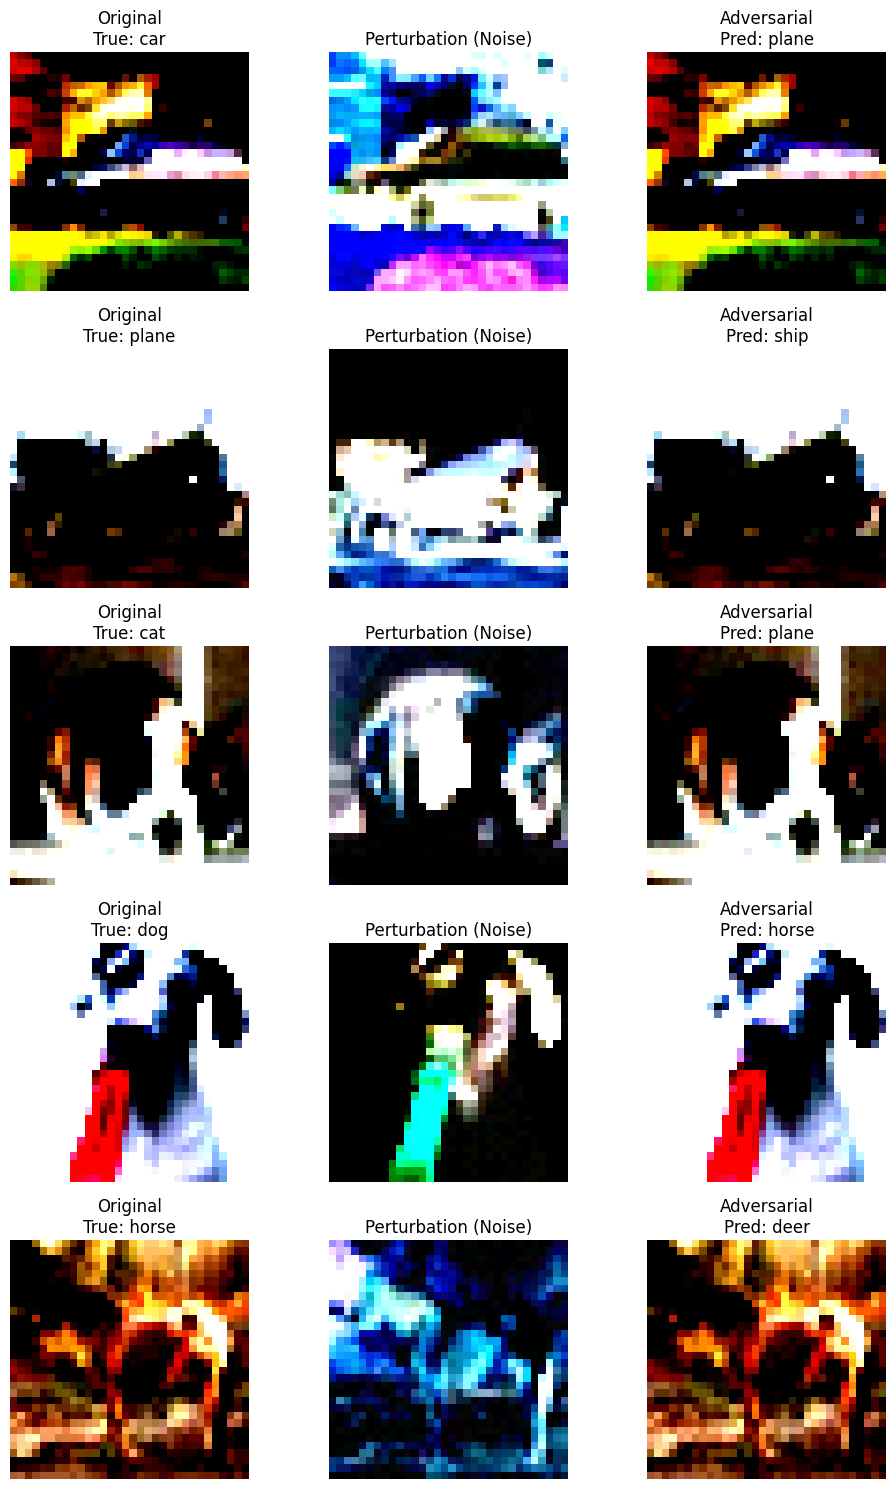

In [46]:
pgd_acc, examples = pgd_attack(model, testloader, 0.03, 0.005, 40)

print(pgd_acc)
plot_examples(examples)

In [48]:
def pgdm_attack(model, loader, epsilon, alpha, pgd_iter, m):
    examples = []
    total = 0
    correct = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        perturbed_images = images.clone().detach()
        momentum = torch.zeros_like(images)
        for _ in range(pgd_iter):
            perturbed_images.requires_grad = True
            outputs = model(perturbed_images)
            loss = F.cross_entropy(outputs, labels)
            
            model.zero_grad()
            loss.backward()
            grad = perturbed_images.grad.data
            momentum = m * grad + (1-m) * momentum
            with torch.no_grad():
                perturbed_images, noise = ps(epsilon, images, perturbed_images + alpha * momentum.sign())
        
        with torch.no_grad():
            outputs_adv = model(perturbed_images)
            _, predicted_adv = torch.max(outputs_adv.data, 1)
            
            if len(examples) < 5:
                for i in range(images.size(0)):
                    if predicted_adv[i] != labels[i]:
                        examples.append((
                            images[i].cpu(), 
                            noise[i].cpu(), 
                            perturbed_images[i].cpu(), 
                            labels[i].cpu(), 
                            predicted_adv[i].cpu()
                        ))
                    if len(examples) >= 5:
                        break
            
            correct += (predicted_adv == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy, examples

7.63


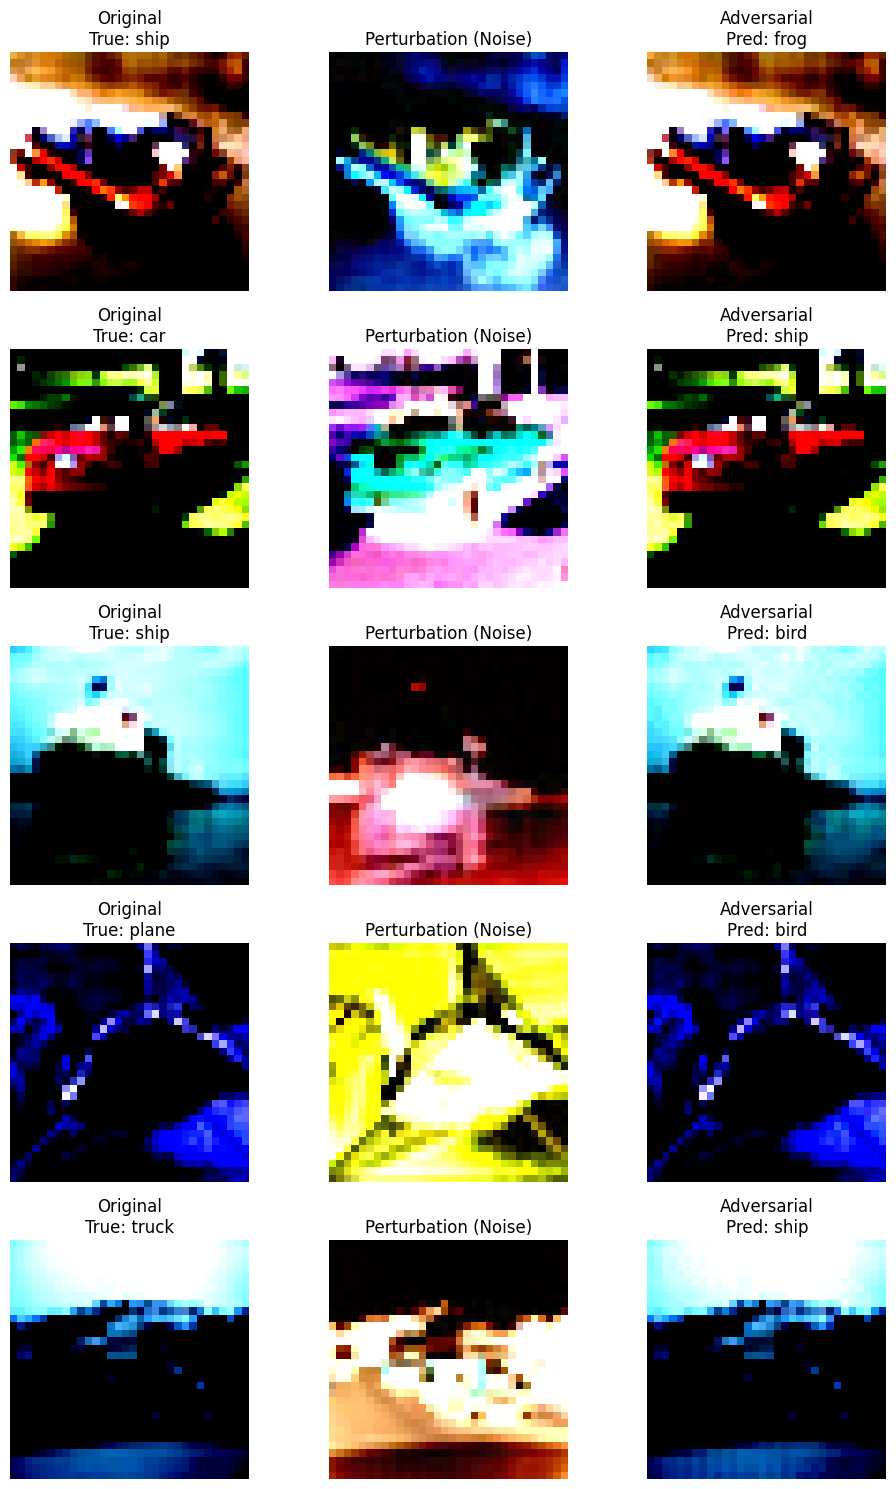

In [70]:
pgdm_acc, examples = pgdm_attack(model, testloader, 0.03, 0.005, 40, 0.75)

print(pgdm_acc)
plot_examples(examples)

In [49]:
def apgd_attack(model, loader, loss_func, epsilon, alpha, pgd_iter, w, initial_step_size):
    examples = []
    total = 0
    correct = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = images.shape[0]

        x = images.clone().detach()
        prev_x = torch.zeros_like(images)
        best_x = images.clone().detach()
        best_loss = torch.full((batch_size,), -float('inf'), device=device)
        
        step_sizes = torch.full((batch_size,), initial_step_size, device=device)
        
        for i in range(pgd_iter):
            x.requires_grad = True
            outputs = model(x)
            loss = loss_func(outputs, labels)
            
            model.zero_grad()
            loss.sum().backward()
            grad = x.grad.data
            
            with torch.no_grad():
                z, _ = ps(epsilon, images, x + step_sizes.view(-1, 1, 1, 1) * grad.sign())
                x_new, _ = ps(epsilon, images, x + alpha * (z - x) + (1-alpha)*(x - prev_x))

                current_loss = loss_func(model(x_new), labels)
                improved = current_loss > best_loss
                best_loss = torch.where(improved, current_loss, best_loss)
                best_x = torch.where(improved.view(-1,1,1,1), x_new, best_x)
                
                prev_x = x.clone()
                x = x_new.clone()
                if i in w:
                    halved = current_loss <= best_loss
                    step_sizes = torch.where(halved, step_sizes / 2.0, step_sizes)
                    best_x = torch.where(halved.view(-1, 1, 1, 1), x, best_x) 

        with torch.no_grad():
            outputs_adv = model(best_x)
            _, predicted_adv = torch.max(outputs_adv.data, 1)
            
            if len(examples) < 5:
                for idx in range(batch_size):
                    if predicted_adv[idx] != labels[idx] and len(examples) < 5:
                        examples.append((
                            images[idx].cpu(), 
                            (best_x[idx] - images[idx]).cpu(), 
                            best_x[idx].cpu(), 
                            labels[idx].cpu(), 
                            predicted_adv[idx].cpu()
                        ))
            
            correct += (predicted_adv == labels).sum().item()
            total += labels.size(0)
    
    return 100 * correct / total, examples

7.59


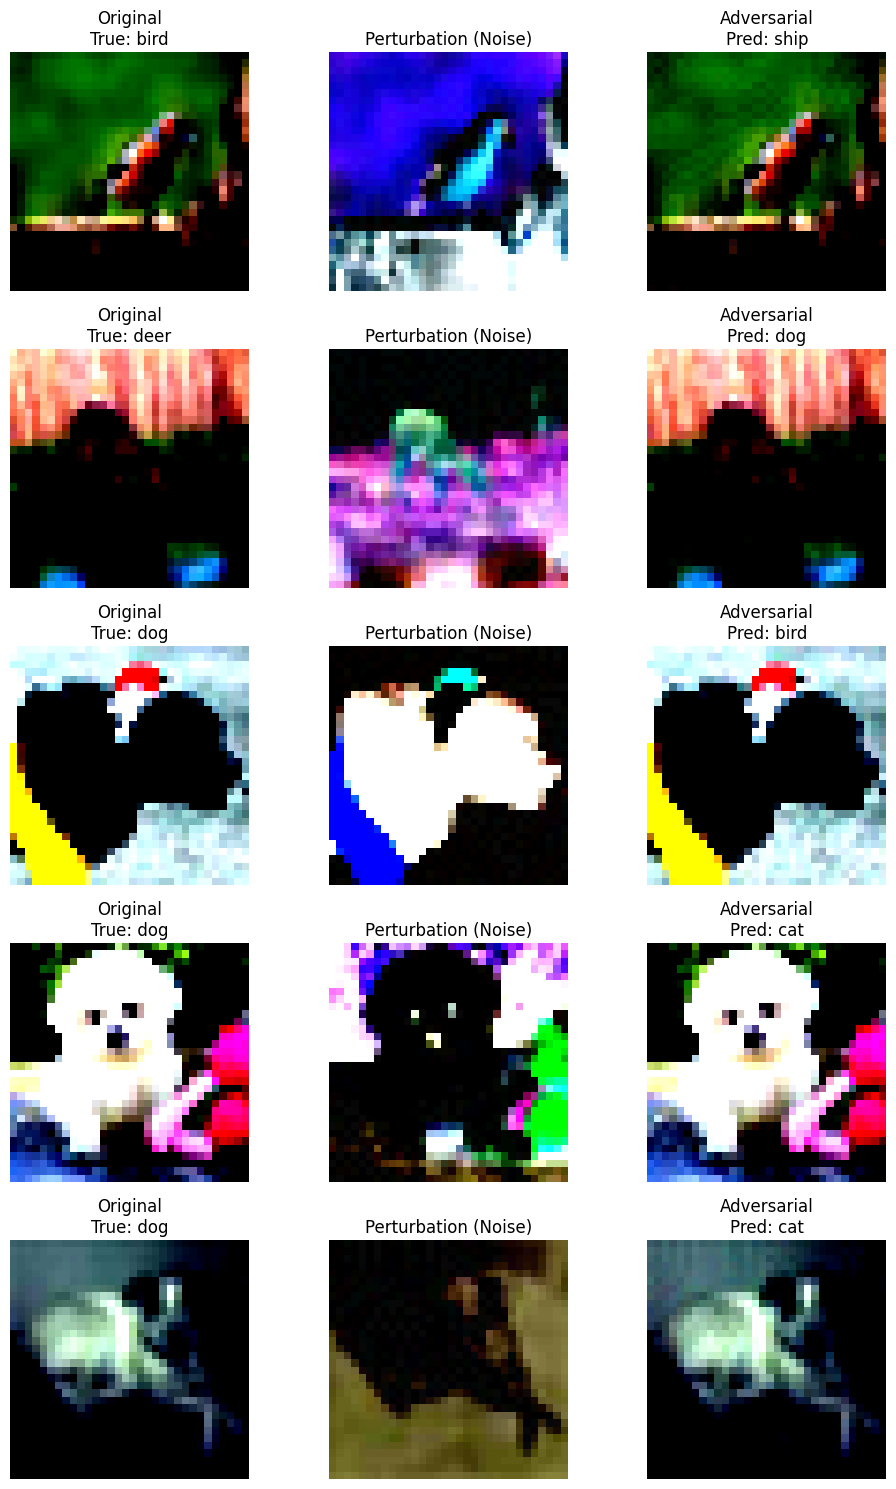

In [79]:
apgd_acc, examples = apgd_attack(model, testloader, nn.CrossEntropyLoss(reduction = 'none'), 0.03, 0.75, 40, [4,14,24,34], 0.06)

print(apgd_acc)
plot_examples(examples)

In [69]:
def cw_loss(logits, targets):
    target = torch.nn.functional.one_hot(targets, num_classes=logits.shape[1]).float()
    target_logits = torch.sum(target * logits, dim=1)
    
    other_logits = logits.clone()
    other_logits[target.bool()] = -float('inf') 
    max_other_logits = other_logits.max(dim=1)[0]
    
    loss = max_other_logits - target_logits
    return loss

7.57


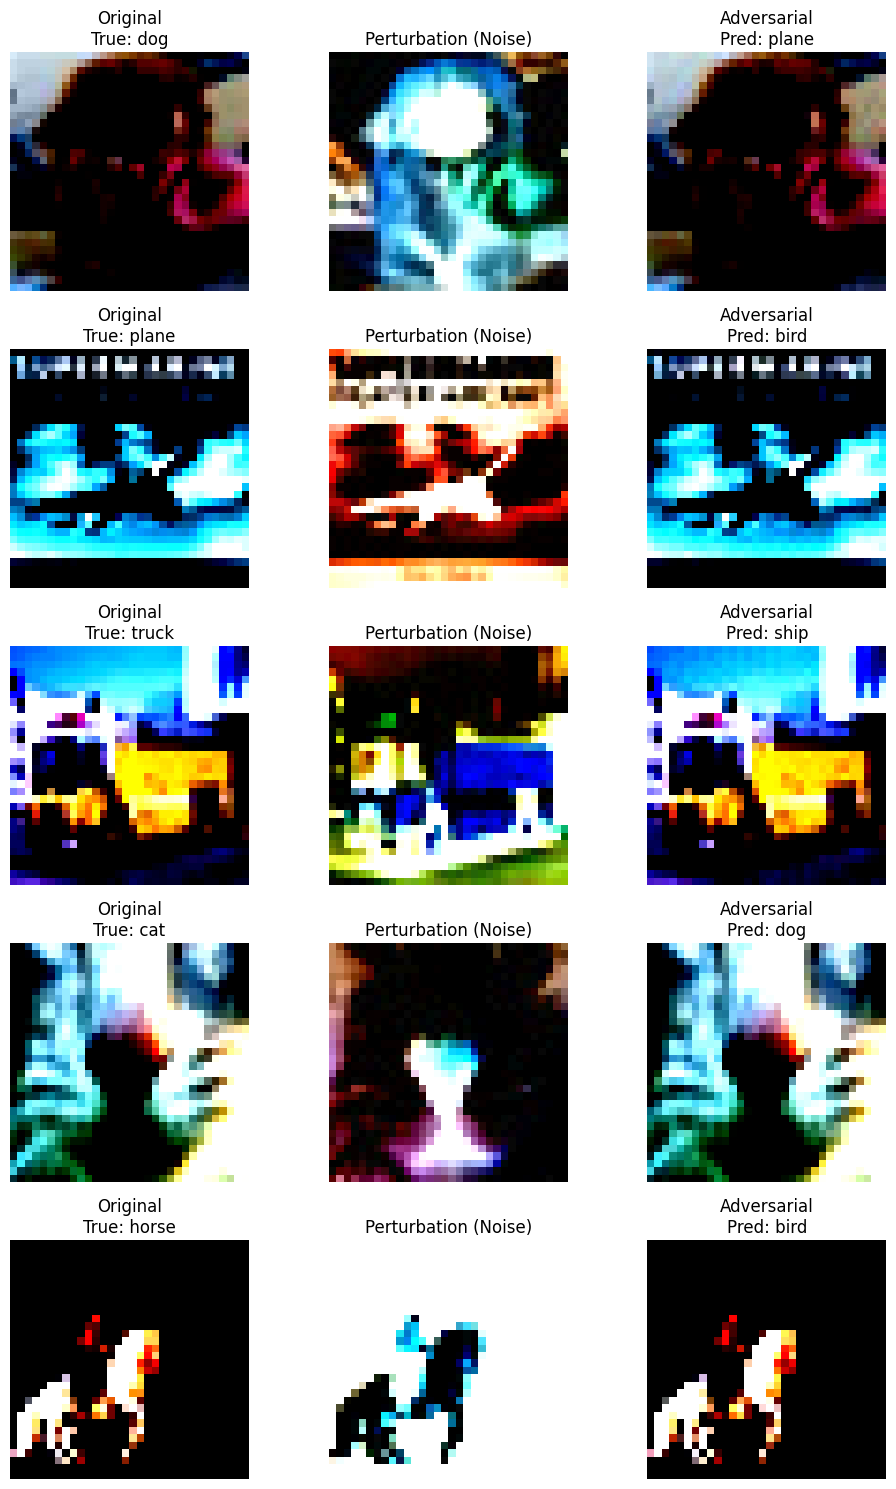

In [76]:
apgd_cw_acc, examples = apgd_attack(model, testloader, cw_loss, 0.03, 0.75, 40, [4,14,24,34], 0.06)

print(apgd_cw_acc)
plot_examples(examples)